# Machine Learning - Assignment 4

### Oscar Fabián Ñáñez Núñez - Juan Camilo Calero Espinosa
### ofnanezn - jccaleroe

In [1]:
#import pylab as pl
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.layers.wrappers import TimeDistributed
from itertools import permutations
import numpy as np
from keras.preprocessing import image
import operator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter

/home/woom05/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1.

## 1a)
![title](nn.jpg)
where $a_{i}=\sum_{j}w_{j}^{i}z_{j}$ , $z_{i}=f_{i}(a_{i})$ for
$i=1,2,3,4$, $z_{5}=a_{5}$ (an input neuron), $f_{2}(x)=\textrm{relu}(x)$,
and $f_{1}(x)=f_{3}(x)=f_{4}(x)=\textrm{sigmoid}(x)$. $\textrm{relu}(x)$
corresponds to a rectifier linear unit transfer function defined as:
$$
\textrm{relu}(x)=\begin{cases}
x & \textrm{if }x\ge0\\
0 & \textrm{otherwise}
\end{cases}
$$

1.a Write a function to simulate the neural network:

In [4]:
def sigmoid(x, derivative=False):
    sigma_x = 1./(1+np.exp(-x))
    if not derivative:
        return sigma_x
    else:
        return sigma_x * (1 - sigma_x)
    
def relu(x, derivative=False):
    if not derivative:
        return max(0,x)
    else:
        return (1 if x > 0 else 0)

In [5]:
def forward_propagate(x, w):
    '''
    x: input value for neuron 5
    w: weights array in the following order
       [w13, w12, w14, w32, w42, w53, w54]
    Returns: a pair of arrays (a, z), where 
             a has the activation values for each neuron, and
             z the output values for each neuron
    '''
    w31, w21, w41, w32, w42, w53, w54 = w[0], w[1], w[2], w[3], w[4], w[5], w[6]
    z = np.zeros(5)
    a = np.zeros(5)
    # your code here
    a[4] = x
    z[4] = a[4]
    a[3] = w54*z[4]
    z[3] = sigmoid(a[3])
    a[2] = w53*z[4]
    z[2] = sigmoid(a[2])
    a[1] = w32*z[2] + w42*z[3]
    z[1] = relu(a[1])
    a[0] = w31*z[2] + w21*z[1] + w41*z[3]
    z[0] = sigmoid(a[0])
    return (a, z)

## 1b)
Deduce the equations to calculate $\delta_{i}$ (the error value per neuron) for all the neurons. Write a function that given a training sample and the weights of the network calculate $\delta_{i}$ for each neuron. Assume a square error loss:
$$ L_2(f, D) =\sum_{(x_{i},r_{i}) \in D} (r_i - f(x_i))^2 $$

In [6]:
def bp(x, y, w):
    '''
    x: input value for neuron 5
    y: output value for neuron 1
    w: weights array in the following order
       [w13, w12, w14, w32, w42, w53, w54]
    Returns: an arr6ay delta with the delta values for each
             neuron
    '''
    w31, w21, w41, w32, w42, w53, w54 = w[0], w[1], w[2], w[3], w[4], w[5], w[6]
    (a, z) = forward_propagate(x, w)
    delta = np.zeros(5)
    dz1 = -2 * (y - z[0])
    da1 = dz1 * sigmoid(a[0],derivative=True)
    delta[0] = da1
    delta[1] = relu(a[1], derivative=True) * w21 * delta[0]
    delta[2] = sigmoid(a[2],derivative=True) * (w31 * delta[0] + w32 * delta[1])
    delta[3] = sigmoid(a[3],derivative=True) * (w42 * delta[1] + w41 * delta[0])
    delta[4] = sigmoid(a[4],derivative=True) * (w53 * delta[2] + w54 * delta[3])
    return delta

## 1c) 
Write a function to update the neural network weights when a new training sample is shown using stochastic gradient descent.

In [8]:
def train_step(x, y, w, eta):
    '''
    x: input value for neuron 5
    y: output value for neuron 1
    w: weights array in the following order
       [w13, w12, w14, w32, w42, w53, w54]
    eta: learning rate
    Returns: updated w array
    '''
    # Calculate dw
    # Your code here
    (a, z) = forward_propagate(x, w)
    delta = bp(x, y, w)
    dw = np.zeros(7)
    dw[0] = delta[0] * z[2]
    dw[1] = delta[0] * z[1]
    dw[2] = delta[0] * z[3]
    dw[3] = delta[1] * z[2]
    dw[4] = delta[1] * z[3]
    dw[5] = delta[2] * z[4]
    dw[6] = delta[3] * z[4]
    for i in range(7):
        w[i] = w[i] - eta * dw[i]
    return w

## 1d )
Use the previous function to train the network with these [training samples](http://fagonzalezo.github.io/ml/samples_assign4.txt).  Plot the evolution of the error and the predictions of the trained network. Write down the weights of the trained network.

In [32]:
dataset = open("samples_assign4.txt", 'r').readlines()[1:]
w = [np.random.randn() for i in range(7)]
print("Initial Weights:")
print(w)

num_iterations = 30
history = []

for j in range(num_iterations):
    error = 0
    for line in dataset:
        (x,y) = map(float, line.strip().split(" "))
        (a,z) = forward_propagate(x, w)
        error += (y - a[0])**2
        w = train_step(x, y, w, 0.01)
    history.append(error)
    
print("\nFinal Weights:")
print(w)

Initial Weights:
[-0.17787225530677167, -0.673664851121428, -0.7073900410972456, 1.8604338726158207, -2.4425535232733657, 0.04799711255492156, 0.07050185781514191]

Final Weights:
[0.9751374825914624, -0.6716357833782265, 0.3147344804174333, 1.8331929175745214, -2.4625116941098417, -0.296466450706958, 0.00229215976011362]


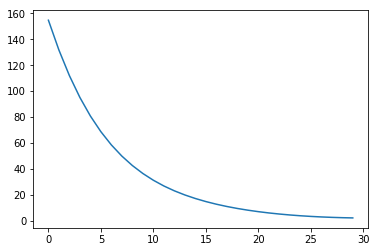

In [33]:
epochs = list(range(num_iterations))
plt.plot(epochs, history)

## 2. (1.0) The hangman

Design a function able to find the missing characters from a word. The function must work as follows:

```
>>> hangman("pe_p_e")
'people'

>>> hangman("phi__sop_y")
'philosophy'

>>> hangman("si_nif_c_nc_")
'significance'

>>> hangman("kn__l_d_e")
'knowledge'

>>> hangman("inte_r_ga_i_n")
'interrogation'
```

The function must be able to deal with up to 4 unknowns in arbitrary length words. The function must work in a reasonable time (max 30 seconds in a laptop). 

In [6]:
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
chars = sorted(list(set(text)))
vocab_size = 57
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print("Total number of chars:", len(text))
print("Vocabulary size:", vocab_size)

('Total number of chars:', 600901)
('Vocabulary size:', 57)


In [7]:
def log_likelihood(model, text):
    probs = model.predict(parse_text(text, vocab_size, padding=True)).squeeze()
    return sum([np.log(probs[i, char_indices[c]]) 
                 for i,c in enumerate(text[1:]) ])

def parse_text(text, vocab_size, padding=False):
    if padding:
        X = np.zeros((1, maxlen, vocab_size), dtype=np.bool)
    else:
        X = np.zeros((1, len(text), vocab_size), dtype=np.bool)
    for t, char in enumerate(text):
        X[0, t, char_indices[char]] = 1
    return X

In [8]:
maxlen = 40
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, vocab_size), return_sequences=True, name="lstm_1"))
model.add(TimeDistributed(Dense(vocab_size), name="dense_1"))#Check names to see how to load weights
model.add(Activation('softmax', name="activation_1"))
h5file = 'lstm-pretrained-weights.hdf5'
optimizer = RMSprop(lr=0.01)
model.load_weights(h5file)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [59]:
alphabet = "abcdefghijklmnopqrstuvwxyz"
 
def beam_search(word, empty_spaces, width):
    s = ((word, empty_spaces), -1)
    frontier = [s]
    count = 0
    for pos in empty_spaces:
        new_frontier = []
        while frontier:
            cur_node = frontier.pop(0)
            cur_word = cur_node[0][0]
            empty = cur_node[0][1]
            cur_pos = empty[0]
            for char in alphabet:
                child_word = cur_word[:cur_pos] + char + cur_word[cur_pos + 1:]
                prediction = log_likelihood(model, child_word)
                child_node = ((child_word,empty[1:]), prediction)
                new_frontier.append(child_node)
        if count == 0:
            new_frontier.sort(key=itemgetter(1), reverse=True)
            frontier = new_frontier
        else:
            new_frontier.sort(key=itemgetter(1),reverse=True)
            frontier = new_frontier[:width]
        count += 1

    return frontier[:10]

In [60]:
def hangman(word):
    ### your code here
    empty_spaces = []
    for i in range(len(word)):
        if word[i] == '_':
            empty_spaces.append(i)
    word = str.replace(word, "_", " ")
    best_results = beam_search(word, empty_spaces, 5)
    return best_results
    #return log_likelihood(model, word)

In [63]:
hangman("phi__sop_y")

[(('philosopay', []), -12.201210714876652),
 (('philosophy', []), -12.705522395670414),
 (('philosopey', []), -14.257561542093754),
 (('philosopty', []), -14.326228715479374),
 (('phinosopty', []), -15.19134908914566)]

In [64]:
hangman("si_nif_c_nc_")

[(('significance', []), -16.644860601983964),
 (('significunce', []), -17.164872373454273),
 (('sitnificance', []), -17.7872135322541),
 (('significence', []), -20.550010630860925),
 (('significancy', []), -21.59570995438844)]

### 3. (2.0) Bird classification. 

1. Direct prediction
   * Download the dataset birds from http://www-cvr.ai.uiuc.edu/ponce_grp/data/.
   * Use [Keras](https://keras.io/) and the [MobileNet](https://keras.io/applications/#mobilenet) pre-trained model, to classify the images in the birds dataset. Construct a confusion matrix that relates the bird classes with the 10 most frequent classes from ImageNet predicted by the model.
2. Transfer learning
   * Use the pre-trained MobileNet model as a feature extractor. Create a new model that replaces the top part of MobileNet with two layers of 256 and 6 neurons respectively.
   * Change the attribute trainable of the other layers to be False. This will prevent the weights of these layers to be changed during training.
   * Train the model with the training images from the bird dataset. 
   * Evaluate the performance over the test dataset reporting the results in a confusion matrix. Discuss the results. 
3. Fine tuning
   * Repeat the experiment from the last question, but this time allow all the layers to be trained. 
   * Compare and discuss the results.